In [1]:
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names, na_values="?",
                 sep=" ", comment='\t', skipinitialspace=True)

df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [2]:
import sklearn 
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

train_stats = df_train.describe().transpose()

numeric_column_names = ['Cylinders', 'Displacement', 
                        'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std = train_stats.loc[col_name, 'std']

    df_train_norm = df_train_norm.astype(float)
    df_test_norm = df_test_norm.astype(float)

    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:,col_name] - mean)/std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:,col_name] - mean)/std


df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
71,15.0,1.480536,1.045447,1.186034,1.076969,-1.080283,72.0,1.0
106,18.0,0.304374,0.351582,-0.120005,-0.234356,-0.193086,73.0,1.0
270,23.8,-0.871788,-0.429017,-0.511817,-0.155890,0.729599,78.0,1.0
348,29.9,-0.871788,-0.939778,-1.034233,-0.720604,1.829723,81.0,1.0
102,11.0,1.480536,1.970600,1.186034,2.390672,-0.547965,73.0,1.0


In [3]:
import torch

v = torch.tensor(df_train_norm['Model Year'].values)
boundries = torch.tensor([73,76,79])

df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundries, right=True)

numeric_column_names.append('Model Year Bucketed')

In [4]:
from torch.nn.functional import one_hot

total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values).to(torch.int64) % total_origin)
# above is the list of lists and each list inside consist three numbers representing one hot encoded vector for each example.


x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)

x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

# same process for test dataset

origin_encoded = one_hot(torch.tensor(df_test_norm['Origin'].values).to(torch.int64) % total_origin)

x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)

x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [5]:
x_train[5]

tensor([ 1.4805,  1.9706,  2.2309,  1.5918, -1.1867,  2.0000,  0.0000,  1.0000,
         0.0000])

In [6]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

In [7]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train, y_train)

torch.manual_seed(42)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

In [8]:
x_train.shape[1]

9

In [9]:
# defining model
import torch.nn as nn 

hidden_units = [8,4]
num_input = x_train.shape[1]
all_layers = []

for unit in hidden_units:
    layer = nn.Linear(num_input, unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    num_input = unit

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
num_epochs = 201
log_epoch = 20

train_loss_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        preds = model(x_batch)[:,0]
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_hist[epoch] += loss.item()

    train_loss_hist[epoch] /= len(train_dl)
    if epoch % log_epoch == 0:
        print(f'Epoch {epoch} loss '
              f'{train_loss_hist[epoch]:.4f}')


Epoch 0 loss 6.0531
Epoch 20 loss 6.2162
Epoch 40 loss 6.1763
Epoch 60 loss 6.2638
Epoch 80 loss 5.9462
Epoch 100 loss 6.2225
Epoch 120 loss 6.0783
Epoch 140 loss 6.2956
Epoch 160 loss 5.7889
Epoch 180 loss 6.1642
Epoch 200 loss 6.3639


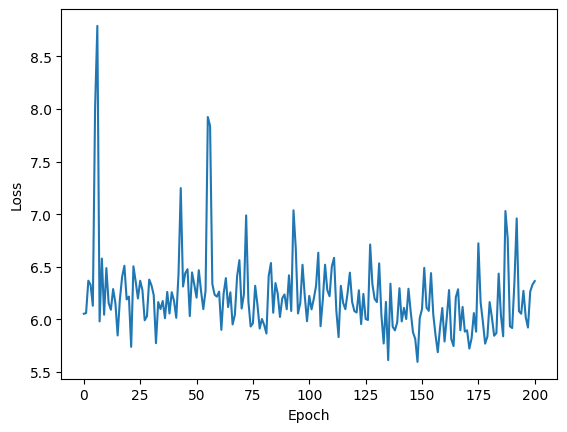

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
with torch.no_grad():
    preds = model(x_test)[:,0]
    loss = loss_fn(preds, y_test)
    print(f'MSE loss: {loss.item():.4f}')
    print(f'MAE loss: {nn.L1Loss()(preds, y_test).item():.4f}')

MSE loss: 15.2152
MAE loss: 2.8211


In [ ]:
# comparing our predictions with real answers side by side 
x_example = x_test[:5]

with torch.no_grad():
    pred = model(x_example).squeeze()
print(f'predicted answer: {pred}')
print(f'real answer: {y_test[:5]}')

predicted answer: tensor([29.8854, 24.7273, 38.6044, 24.3129, 30.5590])
real answer: tensor([26.0000, 21.6000, 36.1000, 26.0000, 27.0000])
